In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# resizes and transforms images

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomRotation(degrees = 45),
    transforms.ToTensor(),])

# applies transformations and loads datasets

validation_dataset = datasets.ImageFolder('M156_Dataset/validation', transform = transform)
train_dataset = datasets.ImageFolder('M156_Dataset/train', transform = transform)

In [3]:
# places data in dataloaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

In [4]:
# move to GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Load the untrained ResNet18 model
model = models.resnet18(pretrained=False)

# Replace the last fully connected layer 
num_ftrs = model.fc.in_features

# Modify the fully connected layers
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 4)  # Output layer with 4 units
)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)

C:\Users\Ben\AppData\Local\anaconda3\envs\NLPTransformer\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ben\AppData\Local\anaconda3\envs\NLPTransformer\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
metric = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)

In [7]:
train_acc = []
validation_acc = []

train_loss = []
valid_loss = []

In [8]:
num_epochs = 50

for i in range(num_epochs):
    running_loss = 0

    for feature, target in train_loader:
        # Set the gradients to zero
        optimizer.zero_grad()
        # Run a forward pass
        target = nn.functional.one_hot(target, num_classes = 4).to(device)
        feature = feature.to(device)
        prediction = model(feature)
        # Calculate the loss
        loss = criterion(prediction, target.double())
        # Compute the gradients
        loss.backward()
        # Update the model's parameters
        optimizer.step()

        running_loss += loss.item()
        acc = metric(prediction, target.argmax(dim=-1))

    acc = metric.compute()
    metric.reset()

    # Set the model to evaluation mode
    model.eval()
    validation_loss = 0.0

    with torch.no_grad():

      for feature, target in val_loader:

          target = nn.functional.one_hot(target, num_classes = 4).to(device)
          feature = feature.to(device)
          prediction = model(feature)
          loss = criterion(prediction, target.double())
          valid_acc = metric(prediction.softmax(dim=-1), target.argmax(dim=-1))

          # Sum the current loss to the validation_loss variable
          validation_loss += loss.item()

    valid_acc = metric.compute()

    print(f'Epoch {i}: Loss: {running_loss}, Accuracy: {acc} | Validation Loss: {validation_loss}, Validation Accuracy: {valid_acc}')

    train_loss.append(float(running_loss))
    valid_loss.append(float(validation_loss))
    train_acc.append(float(acc))
    validation_acc.append(float(valid_acc))
    
    metric.reset()

Epoch 0: Loss: 65.90459363923219, Accuracy: 0.7055237889289856 | Validation Loss: 24.934718292158635, Validation Accuracy: 0.6545454263687134
Epoch 1: Loss: 98.85144884233665, Accuracy: 0.5146666765213013 | Validation Loss: 10.374263379559853, Validation Accuracy: 0.6121212244033813
Epoch 2: Loss: 59.72782655766241, Accuracy: 0.7150475978851318 | Validation Loss: 7.255567285182769, Validation Accuracy: 0.7333333492279053
Epoch 3: Loss: 51.19433419114034, Accuracy: 0.755047619342804 | Validation Loss: 7.23433565041596, Validation Accuracy: 0.7333333492279053
Epoch 4: Loss: 50.25142039166542, Accuracy: 0.7573333382606506 | Validation Loss: 5.575135323565337, Validation Accuracy: 0.7636363506317139
Epoch 5: Loss: 44.8979795054434, Accuracy: 0.7683809399604797 | Validation Loss: 5.651812469111485, Validation Accuracy: 0.7878788113594055
Epoch 6: Loss: 43.7904808716942, Accuracy: 0.7851428389549255 | Validation Loss: 5.567514240409946, Validation Accuracy: 0.7757575511932373
Epoch 7: Loss: 

In [9]:
# save model weights

torch.save(model.state_dict(), 'model_weights.pth')

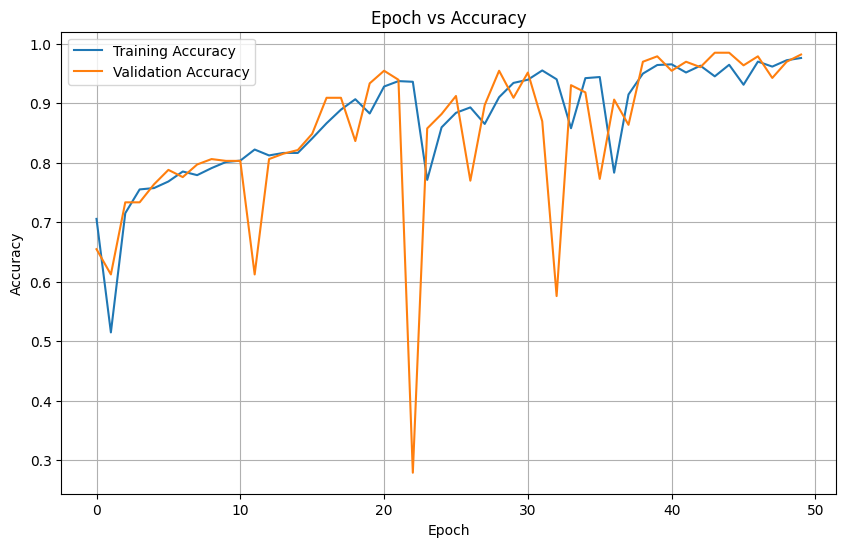

In [10]:
# plot accuracy 

epochs = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, validation_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

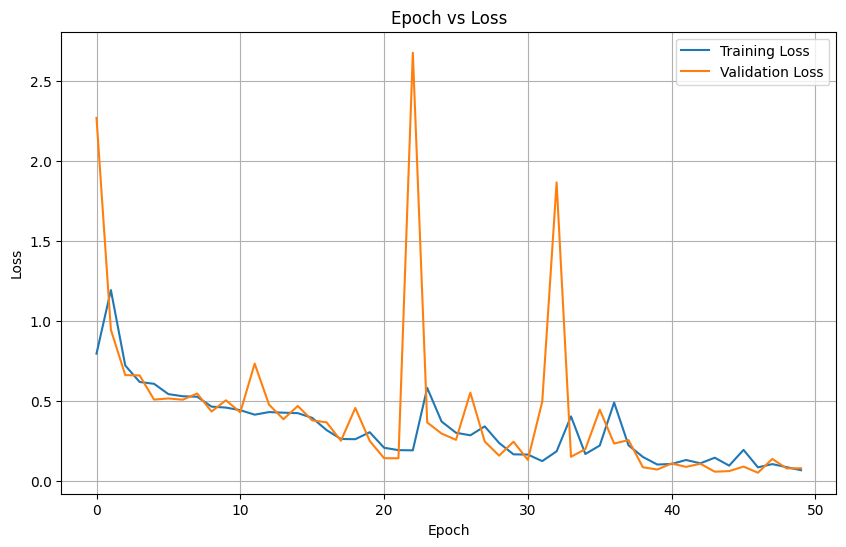

In [15]:
# plot loss

# normalize loss for num batches 
train_loss = np.array(train_loss)
train_loss = train_loss/len(train_loader)

valid_loss = np.array(valid_loss)
valid_loss = valid_loss/len(val_loader)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()